# Market Impact Parameter Calibration

## Objective
Calibrate Almgren-Chriss model parameters using order book data **where possible**, 
and use literature/known values for parameters that **cannot be estimated** from orderbook snapshots.

---

## The Almgren-Chriss Model

The model has two types of costs:

### 1. Temporary Impact (what we CAN estimate)
The instantaneous cost of executing an order, which disappears after execution:
$$
L(\rho) = \psi + \eta \cdot \rho^{\phi}
$$

### 2. Permanent Impact (what we CANNOT estimate from orderbook)
The lasting change in the market price after execution:
$$
\Delta S = k \cdot Q
$$

---

## What Can We Estimate from Orderbook Data?

| Parameter | Estimable? | Method |
|-----------|------------|--------|
| **ψ** (fixed costs) | ️ PARTIAL | Spread from orderbook + **transaction fees** (known) |
| **η** (temporary impact) |  YES | Regression on slippage data |
| **φ** (power exponent) |  NO | Fixed to 0.5 (literature) |
| **k** (permanent impact) |  NO | Calculated via AC2001 rule |

### Components of ψ (fixed costs)

The fixed cost ψ includes **two components**:

1. **Spread** (from orderbook): ~0 bps on Binance (tick size = 0.01 USD on ~95,000 USD)
2. **Transaction fees** (known): **10 bps** (0.1%) on Binance spot

$$
\psi = \psi_{\text{spread}} + \psi_{\text{fees}} \approx 0 + 0.001 = 0.001 \text{ (10 bps)}
$$

> **Note**: The spread on Binance is negligible compared to transaction fees!

### Why can't we estimate k (permanent impact)?

**Permanent impact** = how much the market price moves **permanently** after our execution.

To measure this, we would need:
- Data on actual executed meta-orders
- Price observations **before** and **after** execution
- Time to let temporary effects dissipate

With orderbook snapshots, we only see **instantaneous slippage** (consuming liquidity in the book), 
not the lasting price change. The orderbook refills after we execute, but we don't observe that.

---

## Our Approach

1. **Fix ψ = 0.001 (10 bps)** from known Binance transaction fees
2. **Estimate η** from orderbook slippage data (after subtracting ψ)
3. **Fix φ = 0.5** (theoretical square root law)
4. **Calculate k via Almgren-Chriss 2001 rule**: 10% of daily volume → 1 spread_effectif (≈ fees)

The model becomes:
$$
\text{Slippage}(\rho) = \underbrace{0.001}_{\text{fees}} + \eta \cdot \rho^{0.5}
$$

And for permanent impact (calculated via AC2001 rule):
$$
k = \frac{\text{spread\_effectif}}{0.1 \times V \times S} \approx 8.9 \times 10^{-7}
$$

---

# Setup

In [96]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress
import os
import sys
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

# Import our calibration module
from src.calibration import MarketImpactCalibrator
from src.data import BinanceOrderBookCollector

# Graphics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print(" Imports successful (using src modules)")

 Imports successful (using src modules)


---

# Load Order Book Data

In [97]:
# Find most recent order book file
orderbook_dir = '../data/orderbook'

if not os.path.exists(orderbook_dir):
    print(f" Directory not found: {orderbook_dir}")
    print(f"   Run notebook 05_orderbook_collection.ipynb first")
else:
    files = glob.glob(f'{orderbook_dir}/*_orderbook_*.json')
    
    if not files:
        print(f" No order book files found in {orderbook_dir}")
        print(f"   Run notebook 05_orderbook_collection.ipynb first")
    else:
        # Use most recent file
        orderbook_file = sorted(files)[-1]
        
        print(f" Loading order book data...")
        print(f"   File: {os.path.basename(orderbook_file)}")
        
        with open(orderbook_file, 'r') as f:
            snapshots = json.load(f)
        
        print(f"\n Loaded {len(snapshots)} snapshots")
        print(f"   Symbol: {snapshots[0]['symbol']}")
        print(f"   First: {snapshots[0]['timestamp']}")
        print(f"   Last:  {snapshots[-1]['timestamp']}")

 Loading order book data...
   File: BTCUSDT_orderbook_20251206_184228.json

 Loaded 360 snapshots
   Symbol: BTCUSDT
   First: 2025-12-06T17:40:14.608589
   Last:  2025-12-06T18:42:17.813578


In [98]:
# Load historical daily volume for participation rate calculation
SYMBOL = snapshots[0]['symbol']

# Try multiple sources for daily volume (in order of preference)
DAILY_VOLUME = None

# 1. Try to get real-time volume from Binance API
try:
    collector = BinanceOrderBookCollector(SYMBOL)
    volume_info = collector.get_24h_volume()
    if volume_info:
        DAILY_VOLUME = volume_info['volume']  # Volume in base asset (e.g., BTC)
        print(f" Daily volume from Binance API (24h): {DAILY_VOLUME:,.0f} units/day")
        print(f"   Quote volume: ${volume_info['quoteVolume']:,.0f}")
except Exception as e:
    print(f"️ Could not get volume from Binance API: {e}")

# 2. Fallback to historical data
if DAILY_VOLUME is None:
    try:
        df_params = pd.read_parquet('../data/processed/market_parameters.parquet')
        params = df_params[df_params['symbol'] == SYMBOL].iloc[0]
        DAILY_VOLUME = params['volume_per_day']
        print(f" Daily volume from historical data: {DAILY_VOLUME:,.0f} units/day")
    except Exception as e:
        print(f"️ Could not load historical volume: {e}")

# 3. Last resort: default estimate
if DAILY_VOLUME is None:
    DAILY_VOLUME = 30000  # Default for BTCUSDT
    print(f"️ Using default estimate: {DAILY_VOLUME:,.0f} units/day")
    print(f"   ️ This may affect calibration accuracy - consider running data collection first")

2025-12-27 21:01:26 - market_impact.data.collector - INFO - Collecteur d'orderbook initialisé: BTCUSDT (limit=1000)
2025-12-27 21:01:26 - market_impact.data.collector - INFO - Collecteur d'orderbook initialisé: BTCUSDT (limit=1000)
2025-12-27 21:01:26 - market_impact.data.collector - INFO - Volume 24h BTCUSDT: 4,679.21 (≈ 409,458,137 USDT)
2025-12-27 21:01:26 - market_impact.data.collector - INFO - Volume 24h BTCUSDT: 4,679.21 (≈ 409,458,137 USDT)
 Daily volume from Binance API (24h): 4,679 units/day
   Quote volume: $409,458,137


---

# Mathematical Method

## The Almgren-Chriss Cost Model

Total execution cost has two components:

$$
\text{Total Cost} = \underbrace{\psi + \eta \cdot \rho^{\phi}}_{\text{Temporary Impact}} + \underbrace{k \cdot \rho}_{\text{Permanent Impact}}
$$

where:
- $\rho = Q / V$ : participation rate (order size / daily volume)
- $\psi$ : **fixed costs** (spread + transaction fees)
- $\eta$ : temporary impact coefficient
- $\phi$ : power-law exponent
- $k$ : permanent impact coefficient

## Components of ψ (Fixed Costs)

In the original Almgren-Chriss (2001), ψ = ε = ½ × spread. But for crypto on Binance:

| Component | Value | Source |
|-----------|-------|--------|
| **Spread** | ~0 bps | Orderbook (tick = 0.01$ on 95,000$) |
| **Transaction fees** | **10 bps** | Binance spot fee = 0.1% |
| **Total ψ** | **10 bps** | Fees dominate! |


> **Key insight**: On Binance, transaction fees (10 bps) are **1000x larger** than the spread (~0.01 bps).
> This is very different from traditional markets where spread dominates.

## What We Can Estimate from Orderbook Data

| Component | Parameter | Estimable? | Method |
|-----------|-----------|------------|--------|
| **Fixed costs** | $\psi$ | ️ KNOWN | Binance fees = 0.1% = 10 bps |
| **Temporary** | $\eta$ |  YES | Regression on orderbook slippage |
| **Power** | $\phi$ |  NO | Fixed to 0.5 (literature) |
| **Permanent** | $k$ |  NO | Calculated via AC2001 rule |

## Data Collection

For each orderbook snapshot and order size $Q$, we simulate a market order:

```python
For a BUY order of Q units:
    remaining = Q
    total_cost = 0
    
    For each level (price, quantity) in asks:
        executed = min(remaining, quantity)
        total_cost += executed × price
        remaining -= executed
    
    avg_price = total_cost / Q
    slippage = (avg_price - mid_price) / mid_price
```

This gives us data points $(\rho_i, s_i)$ where $s_i$ is the **orderbook slippage** (without fees).

## Our Estimation Strategy

### Step 1: Fix ψ from known transaction fees

$$
\psi = 0.001 \text{ (10 bps = 0.1\% Binance fee)}
$$

This is the **minimum cost** for any trade, regardless of size.

### Step 2: Estimate η via curve fitting

The orderbook slippage (without fees) follows:
$$
\text{slippage}_{\text{orderbook}}(\rho) = \eta \cdot \rho^{0.5}
$$

We fit this to the observed data to get η.

### Step 3: Calculate k using Almgren-Chriss 2001 rule

The AC2001 rule states: *"Price effects become significant when we sell 10% of the daily volume. 
If 'significant' means one bid-ask spread..."*

For Binance crypto markets, we adapt this:
- **spread_effectif** = half_spread + transaction_fees ≈ **fees** (since spread ~ 0)

$$
\gamma = \frac{\text{spread\_effectif}}{0.1 \times V} \quad \text{(in \$/unit)}
$$

$$
k = \frac{\gamma}{S_0} \approx 8.9 \times 10^{-7}
$$

**Interpretation**: At 10% of daily volume, the permanent impact is ~10 bps (= transaction fees).

## Full Model

The complete cost model is:
$$
\text{Total Slippage}(\rho) = \underbrace{0.001}_{\psi \text{ (fees)}} + \underbrace{\eta \cdot \rho^{0.5}}_{\text{temp. impact}} + \underbrace{k \cdot \rho}_{\text{perm. impact}}
$$

---

# Parameter Estimation

In [99]:
# =============================================================================
# ESTIMATION: η from orderbook, with ψ, φ FIXED, k CALCULATED from AC2001 rule
# =============================================================================

# =============================================================================
# FIXED PARAMETERS
# =============================================================================
PSI_FEES = 0.001      # Transaction fees = 0.1% = 10 bps (Binance spot)
PHI_FIXED = 0.5       # Square root law (theoretical value)

print("="*70)
print("PARAMETER ESTIMATION")
print("="*70)

print(f"\n FIXED PARAMETERS:")
print(f"   ψ = {PSI_FEES} ({PSI_FEES*10000:.0f} bps) [Binance transaction fees = 0.1%]")
print(f"   φ = {PHI_FIXED} [square root law, Kyle 1985]")

# -----------------------------------------------------------------------------
# Step 1: Collect slippage data at various order sizes
# -----------------------------------------------------------------------------
print("\n" + "-"*70)
print(" Step 1: Collecting ORDERBOOK slippage data (excludes fees)...")
print("-"*70)

test_sizes = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]  # BTC
slippage_data = []

for snapshot in snapshots:
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    
    if len(bids) == 0 or len(asks) == 0:
        continue
    
    mid_price = (bids[0, 0] + asks[0, 0]) / 2
    
    for size in test_sizes:
        # Participation rate
        rho = size / DAILY_VOLUME
        
        # Simulate market BUY order (walk up the ask side)
        remaining = size
        total_cost = 0.0
        
        for price, quantity in asks:
            if remaining <= 0:
                break
            executed = min(remaining, quantity)
            total_cost += executed * price
            remaining -= executed
        
        if remaining <= 0:  # Sufficient liquidity
            avg_price = total_cost / size
            # Slippage = relative cost above mid price (ORDERBOOK ONLY, no fees)
            slippage = (avg_price - mid_price) / mid_price
            
            slippage_data.append({
                'size': size,
                'rho': rho,
                'slippage': slippage,
                'mid_price': mid_price
            })

df_slippage = pd.DataFrame(slippage_data)
df_grouped = df_slippage.groupby(['size', 'rho'])['slippage'].agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['size', 'rho', 'slippage_mean', 'slippage_std', 'count']

print(f"   Collected {len(df_slippage)} measurements")
print(f"   Aggregated to {len(df_grouped)} data points")

# Show slippage by size
print(f"\n   Orderbook slippage by order size (EXCLUDING fees):")
for _, row in df_grouped.iterrows():
    print(f"      {row['size']:6.1f} BTC: {row['slippage_mean']*10000:.2f} bps")

print(f"\n    Transaction fees to add: {PSI_FEES*10000:.0f} bps")

# -----------------------------------------------------------------------------
# Step 2: Verify spread is negligible vs fees
# -----------------------------------------------------------------------------
print("\n" + "-"*70)
print(" Step 2: Verify spread vs transaction fees...")
print("-"*70)

# Quoted spread from orderbook
quoted_spreads = []
mid_prices = []
for snapshot in snapshots:
    bids = np.array(snapshot['bids'], dtype=float)
    asks = np.array(snapshot['asks'], dtype=float)
    if len(bids) > 0 and len(asks) > 0:
        mid = (bids[0, 0] + asks[0, 0]) / 2
        mid_prices.append(mid)
        quoted_spreads.append((asks[0, 0] - bids[0, 0]) / 2 / mid)

psi_spread = np.median(quoted_spreads)
S0_current = np.median(mid_prices)  # Current BTC price
smallest_size = min(test_sizes)
psi_slippage_small = df_grouped[df_grouped['size'] == smallest_size]['slippage_mean'].values[0]

print(f"   Quoted half-spread:     {psi_spread*10000:.4f} bps (${psi_spread * S0_current:.4f})")
print(f"   Slippage (0.1 BTC):     {psi_slippage_small*10000:.2f} bps")
print(f"   Transaction fees:       {PSI_FEES*10000:.0f} bps (${PSI_FEES * S0_current:.2f})")
print(f"   Current BTC price:      ${S0_current:,.2f}")
print(f"\n    Fees ({PSI_FEES*10000:.0f} bps) >> Spread ({psi_spread*10000:.2f} bps)")
print(f"      → We use ψ = {PSI_FEES} (fees only, spread negligible)")

# Set psi to transaction fees
psi_est = PSI_FEES

# -----------------------------------------------------------------------------
# Step 3: Estimate η via curve fitting (with ψ FIXED to fees)
# -----------------------------------------------------------------------------
print("\n" + "-"*70)
print(" Step 3: Estimating η (temporary impact coefficient)...")
print("-"*70)
print(f"   Model: orderbook_slippage(ρ) = η·ρ^{PHI_FIXED}")
print(f"   (ψ = fees is ADDED separately, not fitted)")

# Orderbook slippage = η·ρ^0.5 (no constant term, fees added separately)
def slippage_model_orderbook(rho, eta):
    """
    Orderbook slippage model (temporary impact only, no fees).
    
    slippage_orderbook(ρ) = η·ρ^0.5
    
    Note: Transaction fees (ψ) are added separately and not included here.
    """
    return eta * np.power(rho, PHI_FIXED)

# Initial guess for η
p0 = [0.005]

# Bounds: η >= 0
bounds = ([0], [1.0])

try:
    popt, pcov = curve_fit(
        slippage_model_orderbook,
        df_grouped['rho'].values,
        df_grouped['slippage_mean'].values,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    
    eta_est = popt[0]
    eta_std = np.sqrt(np.diag(pcov))[0]
    psi_std = 0.0  # ψ is fixed (known fees)
    k_std = 0.0    # k is calculated
    
    # Goodness of fit (for orderbook slippage model)
    y_pred_orderbook = slippage_model_orderbook(df_grouped['rho'].values, eta_est)
    ss_res = np.sum((df_grouped['slippage_mean'].values - y_pred_orderbook)**2)
    ss_tot = np.sum((df_grouped['slippage_mean'].values - df_grouped['slippage_mean'].mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    rmse = np.sqrt(np.mean((df_grouped['slippage_mean'].values - y_pred_orderbook)**2))
    
    calibration_success = True
    
    print(f"\n η estimation successful!")
    print(f"   η (temp coef)  = {eta_est:.6f} ± {eta_std:.6f}")
    print(f"   R² = {r_squared:.4f}, RMSE = {rmse*10000:.2f} bps")

except RuntimeError as e:
    print(f" Calibration failed: {e}")
    calibration_success = False
    eta_est = 0.005
    eta_std = 0.0
    r_squared = 0.0
    rmse = 0.0
    psi_std = 0.0
    k_std = 0.0

# -----------------------------------------------------------------------------
# Step 4: Calculate k using Almgren-Chriss 2001 rule
# -----------------------------------------------------------------------------
print("\n" + "-"*70)
print(" Step 4: Calculating k (permanent impact) using AC2001 rule...")
print("-"*70)

print(f"""
   Almgren-Chriss (2001) rule of thumb:
   "Price effects become significant when we sell 10% of the daily volume.
    If 'significant' means the price depression is one bid-ask spread..."
   
   Formula: γ = (spread_effectif) / (0.1 × V)
   
   For crypto on Binance:
   - spread_effectif = half_spread + fees ≈ fees (since spread ~ 0)
   - We use the DOLLAR value of the spread_effectif
""")

# Calculate spread_effectif in dollars
half_spread_dollars = psi_spread * S0_current  # ~$0.005 (negligible)
fees_dollars = PSI_FEES * S0_current            # ~$90

spread_effectif_dollars = half_spread_dollars + fees_dollars

print(f"   Half-spread (orderbook): ${half_spread_dollars:.4f}")
print(f"   Fees (Binance):          ${fees_dollars:.2f}")
print(f"   Spread effectif:         ${spread_effectif_dollars:.2f}")
print(f"   V (daily volume):        {DAILY_VOLUME:,.0f} BTC")
print(f"   S0 (current price):      ${S0_current:,.2f}")

# Calculate gamma (in $/BTC)
gamma_est = spread_effectif_dollars / (0.1 * DAILY_VOLUME)
print(f"\n   γ = spread_effectif / (0.1 × V)")
print(f"     = {spread_effectif_dollars:.2f} / (0.1 × {DAILY_VOLUME:,.0f})")
print(f"     = {gamma_est:.6f} $/BTC")

# Convert to dimensionless k
k_est = gamma_est / S0_current
print(f"\n   k = γ / S0 = {gamma_est:.6f} / {S0_current:,.2f}")
print(f"     = {k_est:.2e}")

# Verification
print(f"\n    VERIFICATION:")
q0_10pct = 0.1 * DAILY_VOLUME
impact_10pct_dollars = gamma_est * q0_10pct
impact_10pct_bps = impact_10pct_dollars / S0_current * 10000
print(f"   At 10% of volume ({q0_10pct:.0f} BTC):")
print(f"   Impact = γ × q0 = {gamma_est:.6f} × {q0_10pct:.0f} = ${impact_10pct_dollars:.2f}")
print(f"          = {impact_10pct_bps:.1f} bps")
print(f"   Expected (spread_effectif): {spread_effectif_dollars/S0_current*10000:.1f} bps ")

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print(f"\n" + "="*70)
print("CALIBRATED PARAMETERS:")
print("="*70)
print(f"\n   FIXED:")
print(f"   ─────────────────────────────────────────────")
print(f"   ψ (fees)       = {psi_est:.6f}  ({psi_est*10000:.0f} bps) [Binance 0.1%]")
print(f"   φ (exponent)   = {PHI_FIXED:.2f} [square root law]")

print(f"\n   ESTIMATED FROM ORDERBOOK:")
print(f"   ─────────────────────────────────────────────")
print(f"   η (temp coef)  = {eta_est:.6f} ± {eta_std:.6f}")

print(f"\n   CALCULATED FROM AC2001 RULE:")
print(f"   ─────────────────────────────────────────────")
print(f"   k (perm coef)  = {k_est:.2e}")
print(f"   γ (in $/BTC)   = {gamma_est:.6f}")
print("="*70)

# -----------------------------------------------------------------------------
# Define full model for later use
# -----------------------------------------------------------------------------
def slippage_model_temp_only(rho, eta):
    """Temporary impact model with fees: ψ + η·ρ^0.5"""
    return psi_est + eta * np.power(rho, PHI_FIXED)

def impact_model(rho, psi, eta, k):
    """Full Almgren-Chriss model: ψ + η·ρ^0.5 + k·ρ"""
    return psi + eta * np.power(rho, PHI_FIXED) + k * rho

PARAMETER ESTIMATION

 FIXED PARAMETERS:
   ψ = 0.001 (10 bps) [Binance transaction fees = 0.1%]
   φ = 0.5 [square root law, Kyle 1985]

----------------------------------------------------------------------
 Step 1: Collecting ORDERBOOK slippage data (excludes fees)...
----------------------------------------------------------------------
   Collected 3237 measurements
   Aggregated to 9 data points

   Orderbook slippage by order size (EXCLUDING fees):
         0.1 BTC: 0.01 bps
         0.5 BTC: 0.04 bps
         1.0 BTC: 0.08 bps
         2.0 BTC: 0.18 bps
         5.0 BTC: 0.47 bps
        10.0 BTC: 0.85 bps
        20.0 BTC: 1.42 bps
        50.0 BTC: 2.95 bps
       100.0 BTC: 5.92 bps

    Transaction fees to add: 10 bps

----------------------------------------------------------------------
 Step 2: Verify spread vs transaction fees...
----------------------------------------------------------------------
   Quoted half-spread:     0.0006 bps ($0.0050)
   Slippage (0.1 BTC): 

---

# Visualization

 Plot saved to: ../results/calibration_with_fees.png


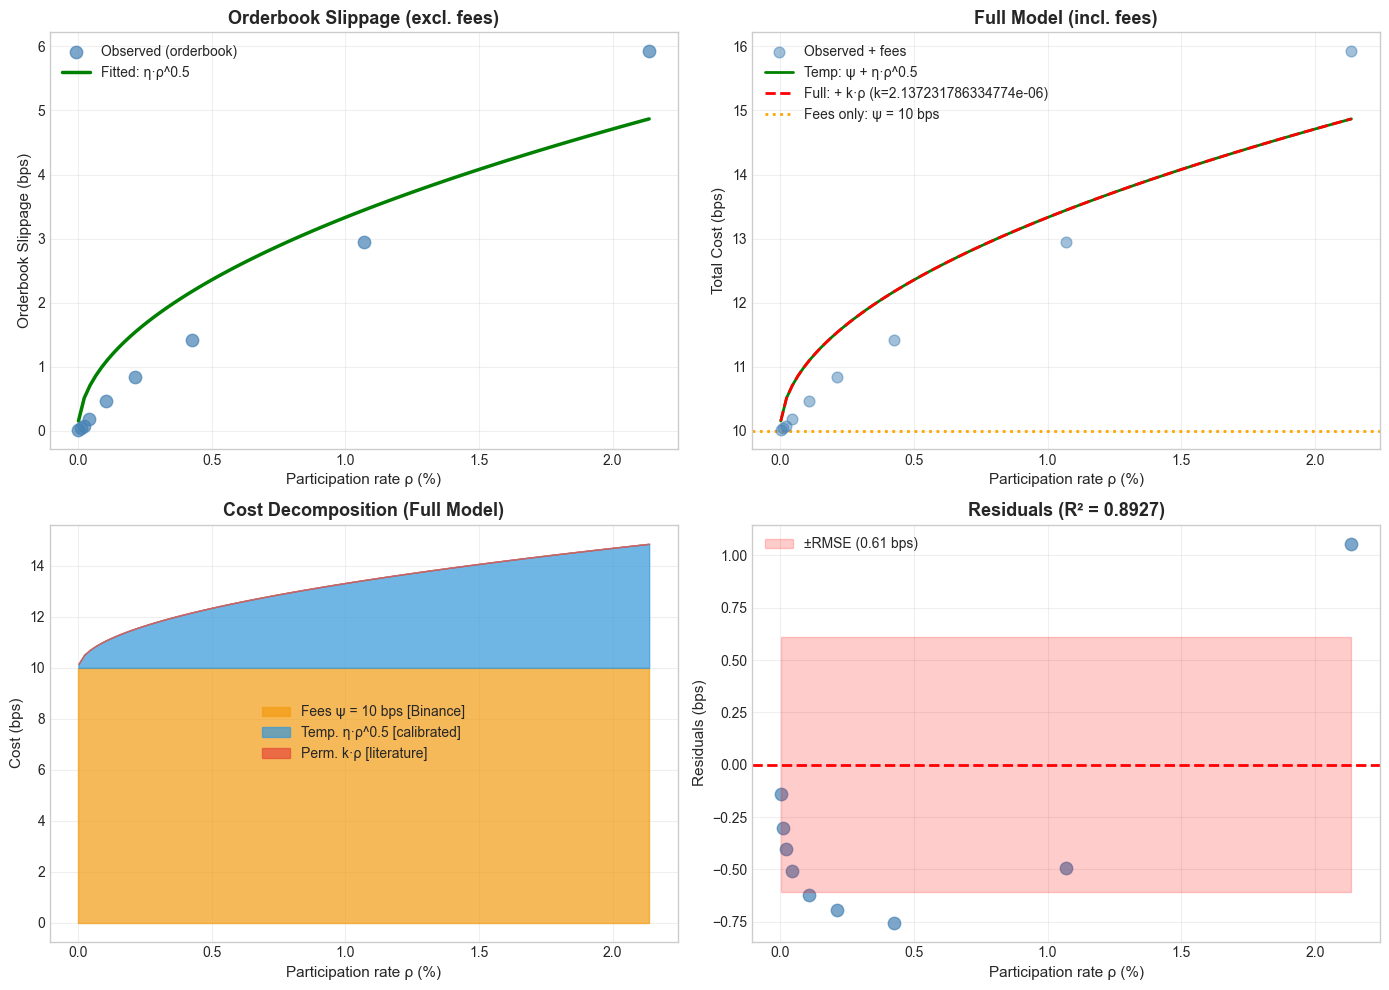

In [100]:
if calibration_success:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Generate smooth curve for plotting
    rho_smooth = np.linspace(df_grouped['rho'].min(), df_grouped['rho'].max(), 100)
    
    # Orderbook slippage model (what we fit)
    slippage_orderbook = eta_est * np.power(rho_smooth, PHI_FIXED)
    
    # Full temporary impact model (with fees)
    slippage_temp_with_fees = psi_est + eta_est * np.power(rho_smooth, PHI_FIXED)
    
    # Full model (including k from literature)
    slippage_full = psi_est + eta_est * np.power(rho_smooth, PHI_FIXED) + k_est * rho_smooth
    
    # ==========================================================================
    # Plot 1: Orderbook Slippage Model vs Data
    # ==========================================================================
    ax = axes[0, 0]
    ax.scatter(df_grouped['rho'] * 100, df_grouped['slippage_mean'] * 10000,
               alpha=0.7, s=80, label='Observed (orderbook)', zorder=3, color='steelblue')
    ax.plot(rho_smooth * 100, slippage_orderbook * 10000, 'g-', linewidth=2.5,
            label=f'Fitted: η·ρ^{PHI_FIXED}', zorder=2)
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Orderbook Slippage (bps)', fontsize=11)
    ax.set_title('Orderbook Slippage (excl. fees)', fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ==========================================================================
    # Plot 2: Full Model with Fees
    # ==========================================================================
    ax = axes[0, 1]
    # Add fees to observed data for comparison
    ax.scatter(df_grouped['rho'] * 100, (df_grouped['slippage_mean'] + psi_est) * 10000,
               alpha=0.5, s=60, label='Observed + fees', zorder=3, color='steelblue')
    ax.plot(rho_smooth * 100, slippage_temp_with_fees * 10000, 'g-', linewidth=2,
            label=f'Temp: ψ + η·ρ^{PHI_FIXED}', zorder=2)
    ax.plot(rho_smooth * 100, slippage_full * 10000, 'r--', linewidth=2,
            label=f'Full: + k·ρ (k={k_est})', zorder=2)
    ax.axhline(psi_est * 10000, color='orange', linestyle=':', linewidth=2,
               label=f'Fees only: ψ = {psi_est*10000:.0f} bps')
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Total Cost (bps)', fontsize=11)
    ax.set_title('Full Model (incl. fees)', fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ==========================================================================
    # Plot 3: Cost Decomposition (Full Model)
    # ==========================================================================
    ax = axes[1, 0]
    cost_fees = psi_est * np.ones_like(rho_smooth)
    cost_temp = eta_est * np.power(rho_smooth, PHI_FIXED)
    cost_perm = k_est * rho_smooth
    
    ax.fill_between(rho_smooth * 100, 0, cost_fees * 10000,
                    alpha=0.7, label=f'Fees ψ = {psi_est*10000:.0f} bps [Binance]', color='#f39c12')
    ax.fill_between(rho_smooth * 100, cost_fees * 10000,
                    (cost_fees + cost_temp) * 10000,
                    alpha=0.7, label=f'Temp. η·ρ^{PHI_FIXED} [calibrated]', color='#3498db')
    ax.fill_between(rho_smooth * 100, (cost_fees + cost_temp) * 10000,
                    (cost_fees + cost_temp + cost_perm) * 10000,
                    alpha=0.7, label=f'Perm. k·ρ [literature]', color='#e74c3c')
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Cost (bps)', fontsize=11)
    ax.set_title('Cost Decomposition (Full Model)', fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # ==========================================================================
    # Plot 4: Residuals (Orderbook Model)
    # ==========================================================================
    ax = axes[1, 1]
    y_pred = slippage_model_orderbook(df_grouped['rho'].values, eta_est)
    residuals = (df_grouped['slippage_mean'].values - y_pred) * 10000
    
    ax.scatter(df_grouped['rho'] * 100, residuals, alpha=0.7, s=80, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.fill_between([df_grouped['rho'].min() * 100, df_grouped['rho'].max() * 100],
                    -rmse * 10000, rmse * 10000, alpha=0.2, color='red',
                    label=f'±RMSE ({rmse*10000:.2f} bps)')
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Residuals (bps)', fontsize=11)
    ax.set_title(f'Residuals (R² = {r_squared:.4f})', fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs('../results', exist_ok=True)
    plt.savefig('../results/calibration_with_fees.png', dpi=150, bbox_inches='tight')
    print(f" Plot saved to: ../results/calibration_with_fees.png")
    
    plt.show()
else:
    print("️ Calibration failed, skipping visualization")

---

# Summary & Save Results

In [101]:
print("="*70)
print("CALIBRATION SUMMARY")
print("="*70)

print(f"\nSymbol: {SYMBOL}")
print(f"Snapshots used: {len(snapshots)}")
print(f"Daily volume: {DAILY_VOLUME:,.0f} units/day")

print("\n" + "-"*70)
print("FIXED PARAMETERS:")
print("-"*70)
print(f"  ψ  (transaction fees)  = {psi_est:.6f}  ({psi_est*10000:.0f} bps) [Binance 0.1%]")
print(f"  φ  (power exponent)    = {PHI_FIXED:.2f} [square root law, Kyle 1985]")

print("\n" + "-"*70)
print("ESTIMATED FROM ORDERBOOK DATA:")
print("-"*70)
print(f"  η  (temporary coef)    = {eta_est:.6f} ± {eta_std:.6f}")

print("\n" + "-"*70)
print("CALCULATED VIA AC2001 RULE:")
print("-"*70)
print(f"  k  (permanent coef)    = {k_est:.2e}")
print(f"  γ  (in $/BTC)          = {gamma_est:.6f}")
print(f"  Interpretation: 10% of daily volume → ~10 bps permanent impact")
print("-"*70)

print(f"\n Key insight:")
print(f"   On Binance, transaction FEES (10 bps) >> spread (~0 bps)")
print(f"   → ψ is dominated by fees, not spread")

print(f"\nFull Almgren-Chriss model:")
print(f"   Total_Cost(ρ) = ψ + η·ρ^{PHI_FIXED} + k·ρ")
print(f"                 = {psi_est*10000:.0f} bps + {eta_est:.4f}·ρ^0.5 + {k_est:.2e}·ρ")

print(f"\nGoodness of fit (orderbook slippage model):")
print(f"  R² = {r_squared:.4f}")
print(f"  RMSE = {rmse*10000:.2f} bps")

# Example calculations with full model
print("\n" + "-"*70)
print("EXAMPLE COST ESTIMATES (Full Model):")
print("-"*70)
example_sizes = [1, 10, 50, 100, 1000]
for size in example_sizes:
    rho = size / DAILY_VOLUME
    cost_fees = psi_est
    cost_temp = eta_est * np.power(rho, PHI_FIXED)
    cost_perm = k_est * rho
    cost_total = cost_fees + cost_temp + cost_perm
    print(f"  {size:4d} BTC (ρ={rho*100:.3f}%):")
    print(f"      Fees: {cost_fees*10000:.1f} bps | Temp: {cost_temp*10000:.2f} bps | Perm: {cost_perm*10000:.4f} bps | Total: {cost_total*10000:.2f} bps")

print("="*70)

CALIBRATION SUMMARY

Symbol: BTCUSDT
Snapshots used: 360
Daily volume: 4,679 units/day

----------------------------------------------------------------------
FIXED PARAMETERS:
----------------------------------------------------------------------
  ψ  (transaction fees)  = 0.001000  (10 bps) [Binance 0.1%]
  φ  (power exponent)    = 0.50 [square root law, Kyle 1985]

----------------------------------------------------------------------
ESTIMATED FROM ORDERBOOK DATA:
----------------------------------------------------------------------
  η  (temporary coef)    = 0.003331 ± 0.000321

----------------------------------------------------------------------
CALCULATED VIA AC2001 RULE:
----------------------------------------------------------------------
  k  (permanent coef)    = 2.14e-06
  γ  (in $/BTC)          = 0.191731
  Interpretation: 10% of daily volume → ~10 bps permanent impact
----------------------------------------------------------------------

 Key insight:
   On Binance, 

---

# Calibration for Quadratic Model (AC2001 Original)

The original Almgren-Chriss (2001) model uses a **quadratic** cost function:
$$
L(\rho) = \eta_{quad} \cdot \rho^2
$$

This is different from the **square-root** law we calibrated above (φ = 0.5).

To use the same orderbook data with the quadratic model, we need to recalibrate η.

In [102]:
# =============================================================================
# CALIBRATION FOR QUADRATIC MODEL (AC2001 ORIGINAL)
# =============================================================================

print("="*70)
print("CALIBRATION FOR QUADRATIC MODEL (φ = 1)")
print("="*70)

print("""
The original Almgren-Chriss (2001) model uses QUADRATIC execution costs:

    L(ρ) = η_quad · ρ²

This differs from the square-root model (φ=0.5) we calibrated above.
We now fit η_quad directly to the orderbook data using φ=1.
""")

# -----------------------------------------------------------------------------
# Fit quadratic model: slippage = η_quad · ρ^2
# -----------------------------------------------------------------------------
PHI_QUADRATIC = 1.0  # Quadratic model

def slippage_model_quadratic(rho, eta):
    """Quadratic slippage model: η·ρ²"""
    return eta * np.power(rho, PHI_QUADRATIC)

# Fit to orderbook data
try:
    popt_quad, pcov_quad = curve_fit(
        slippage_model_quadratic,
        df_grouped['rho'].values,
        df_grouped['slippage_mean'].values,
        p0=[1.0],  # Higher initial guess for quadratic
        bounds=([0], [1000]),
        maxfev=10000
    )
    
    eta_quadratic = popt_quad[0]
    eta_quadratic_std = np.sqrt(np.diag(pcov_quad))[0]
    
    # Goodness of fit
    y_pred_quad = slippage_model_quadratic(df_grouped['rho'].values, eta_quadratic)
    ss_res_quad = np.sum((df_grouped['slippage_mean'].values - y_pred_quad)**2)
    ss_tot_quad = np.sum((df_grouped['slippage_mean'].values - df_grouped['slippage_mean'].mean())**2)
    r_squared_quad = 1 - (ss_res_quad / ss_tot_quad)
    rmse_quad = np.sqrt(np.mean((df_grouped['slippage_mean'].values - y_pred_quad)**2))
    
    print(f" Quadratic model calibration successful!")
    print(f"\n   η_quadratic = {eta_quadratic:.4f} ± {eta_quadratic_std:.4f}")
    print(f"   R² = {r_squared_quad:.4f}")
    print(f"   RMSE = {rmse_quad*10000:.2f} bps")
    
    calibration_quad_success = True

except RuntimeError as e:
    print(f" Quadratic calibration failed: {e}")
    eta_quadratic = 1.0
    eta_quadratic_std = 0.0
    r_squared_quad = 0.0
    rmse_quad = 0.0
    calibration_quad_success = False

# -----------------------------------------------------------------------------
# Compare the two models
# -----------------------------------------------------------------------------
print(f"\n" + "-"*70)
print("COMPARISON: Square-Root vs Quadratic Model")
print("-"*70)

print(f"\n{'Model':<20} {'η':<15} {'φ':<8} {'R²':<10} {'RMSE (bps)':<12}")
print("-"*70)
print(f"{'Square-Root':<20} {eta_est:<15.6f} {PHI_FIXED:<8.1f} {r_squared:<10.4f} {rmse*10000:<12.2f}")
print(f"{'Quadratic (AC2001)':<20} {eta_quadratic:<15.4f} {PHI_QUADRATIC:<8.1f} {r_squared_quad:<10.4f} {rmse_quad*10000:<12.2f}")

# Show impact at different participation rates
print(f"\n" + "-"*70)
print("IMPACT COMPARISON AT DIFFERENT PARTICIPATION RATES:")
print("-"*70)
print(f"\n{'ρ (%)':<10} {'Square-Root (bps)':<20} {'Quadratic (bps)':<20} {'Ratio':<10}")
print("-"*70)

for rho_pct in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    rho = rho_pct / 100
    impact_sqrt = eta_est * np.power(rho, PHI_FIXED) * 10000
    impact_quad = eta_quadratic * np.power(rho, PHI_QUADRATIC) * 10000
    ratio = impact_sqrt / impact_quad if impact_quad > 0 else float('inf')
    print(f"{rho_pct:<10.1f} {impact_sqrt:<20.2f} {impact_quad:<20.2f} {ratio:<10.1f}")

print(f"\n Key insight:")
print(f"   - Square-root model (φ=0.5) fits better for small participation rates")
print(f"   - Quadratic model (φ=1) is the original AC2001 formulation")
print(f"   - η_quadratic >> η_sqrt because ρ² << ρ^0.5 for small ρ")

CALIBRATION FOR QUADRATIC MODEL (φ = 1)

The original Almgren-Chriss (2001) model uses QUADRATIC execution costs:

    L(ρ) = η_quad · ρ²

This differs from the square-root model (φ=0.5) we calibrated above.
We now fit η_quad directly to the orderbook data using φ=1.

 Quadratic model calibration successful!

   η_quadratic = 0.0280 ± 0.0006
   R² = 0.9951
   RMSE = 0.13 bps

----------------------------------------------------------------------
COMPARISON: Square-Root vs Quadratic Model
----------------------------------------------------------------------

Model                η               φ        R²         RMSE (bps)  
----------------------------------------------------------------------
Square-Root          0.003331        0.5      0.8927     0.61        
Quadratic (AC2001)   0.0280          1.0      0.9951     0.13        

----------------------------------------------------------------------
IMPACT COMPARISON AT DIFFERENT PARTICIPATION RATES:
------------------------------

 Comparison plot saved to: ../results/calibration_model_comparison.png


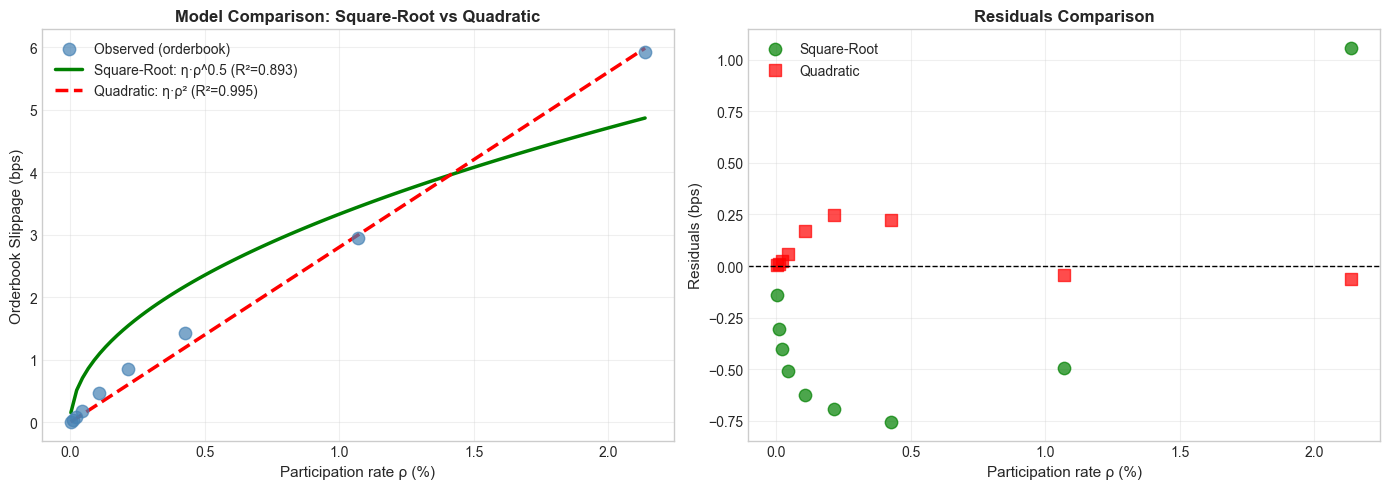

In [103]:
# =============================================================================
# VISUALIZATION: Compare Square-Root vs Quadratic Models
# =============================================================================

if calibration_success and calibration_quad_success:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    rho_smooth = np.linspace(df_grouped['rho'].min(), df_grouped['rho'].max(), 100)
    
    # Plot 1: Both models vs data
    ax = axes[0]
    ax.scatter(df_grouped['rho'] * 100, df_grouped['slippage_mean'] * 10000,
               alpha=0.7, s=80, label='Observed (orderbook)', zorder=3, color='steelblue')
    ax.plot(rho_smooth * 100, eta_est * np.power(rho_smooth, PHI_FIXED) * 10000, 
            'g-', linewidth=2.5, label=f'Square-Root: η·ρ^0.5 (R²={r_squared:.3f})')
    ax.plot(rho_smooth * 100, eta_quadratic * np.power(rho_smooth, PHI_QUADRATIC) * 10000, 
            'r--', linewidth=2.5, label=f'Quadratic: η·ρ² (R²={r_squared_quad:.3f})')
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Orderbook Slippage (bps)', fontsize=11)
    ax.set_title('Model Comparison: Square-Root vs Quadratic', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Residuals comparison
    ax = axes[1]
    residuals_sqrt = (df_grouped['slippage_mean'].values - eta_est * np.power(df_grouped['rho'].values, PHI_FIXED)) * 10000
    residuals_quad = (df_grouped['slippage_mean'].values - eta_quadratic * np.power(df_grouped['rho'].values, PHI_QUADRATIC)) * 10000
    
    ax.scatter(df_grouped['rho'] * 100, residuals_sqrt, alpha=0.7, s=80, label='Square-Root', color='green')
    ax.scatter(df_grouped['rho'] * 100, residuals_quad, alpha=0.7, s=80, label='Quadratic', color='red', marker='s')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Participation rate ρ (%)', fontsize=11)
    ax.set_ylabel('Residuals (bps)', fontsize=11)
    ax.set_title('Residuals Comparison', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/calibration_model_comparison.png', dpi=150, bbox_inches='tight')
    print(f" Comparison plot saved to: ../results/calibration_model_comparison.png")
    plt.show()
else:
    print("️ Calibration failed for one or both models")

In [104]:
# =============================================================================
# SAVE CALIBRATED PARAMETERS FOR BOTH MODELS
# =============================================================================

results = {
    'symbol': SYMBOL,
    'timestamp': pd.Timestamp.now().isoformat(),
    'num_snapshots': len(snapshots),
    'daily_volume': float(DAILY_VOLUME),
    'price': float(S0_current),
    'estimation_method': 'hybrid',
    
    # =========================================================================
    # POWER-LAW MODEL (φ = 0.5) - For notebook 05
    # =========================================================================
    'powerlaw_model': {
        'description': 'Power-law model with φ=0.5 (square-root law)',
        'formula': 'L(ρ) = ψ + η·ρ^0.5 + k·ρ',
        'use_in': 'notebook 05 (numerical optimization)',
        'parameters': {
            'psi': float(psi_est),
            'eta': float(eta_est),
            'phi': float(PHI_FIXED),
            'k': float(k_est),
        },
        'uncertainties': {
            'eta_std': float(eta_std),
        },
        'goodness_of_fit': {
            'r_squared': float(r_squared),
            'rmse_bps': float(rmse * 10000),
        }
    },
    
    # =========================================================================
    # QUADRATIC MODEL (φ = 1) - For notebook 04 (AC2001 original)
    # =========================================================================
    'quadratic_model': {
        'description': 'Quadratic model (original AC2001)',
        'formula': 'L(ρ) = ψ + η·ρ² + k·ρ',
        'use_in': 'notebook 04 (analytical solution)',
        'parameters': {
            'psi': float(psi_est),
            'eta': float(eta_quadratic),
            'phi': 1.0,
            'k': float(k_est),
        },
        'uncertainties': {
            'eta_std': float(eta_quadratic_std),
        },
        'goodness_of_fit': {
            'r_squared': float(r_squared_quad),
            'rmse_bps': float(rmse_quad * 10000),
        }
    },
    
    # =========================================================================
    # COMMON PARAMETERS
    # =========================================================================
    'common_parameters': {
        'psi': float(psi_est),
        'psi_source': 'binance_transaction_fees (0.1%)',
        'k': float(k_est),
        'k_source': 'AC2001 rule: 10% of volume -> 10 bps impact',
        'gamma': float(gamma_est),
    },
    
    # =========================================================================
    # LEGACY FORMAT (for backward compatibility)
    # =========================================================================
    'parameters': {
        'psi': float(psi_est),
        'eta': float(eta_est),  # Power-law eta (default)
        'eta_quadratic': float(eta_quadratic),  # Quadratic eta
        'phi': float(PHI_FIXED),
        'k': float(k_est),
        'gamma': float(gamma_est),
    },
    'parameter_sources': {
        'psi': 'binance_transaction_fees',
        'eta': 'estimated_from_orderbook (phi=0.5)',
        'eta_quadratic': 'estimated_from_orderbook (phi=1.0)',
        'phi': 'fixed_from_literature',
        'k': 'calculated_from_AC2001_rule',
    },
    
    # =========================================================================
    # METADATA
    # =========================================================================
    'cost_components': {
        'psi_fees_bps': float(psi_est * 10000),
        'psi_spread_bps': float(psi_spread * 10000),
        'spread_effectif_dollars': float(spread_effectif_dollars),
        'note': 'On Binance, fees (10 bps) >> spread (~0 bps)'
    },
    'metadata': {
        'orderbook_file': os.path.basename(orderbook_file),
        'estimation_note': 'Two models calibrated: power-law (phi=0.5) and quadratic (phi=1.0)',
    }
}

os.makedirs('../results', exist_ok=True)
output_file = '../results/calibrated_parameters.json'

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f" Parameters saved to: {output_file}")

print(f"\n" + "="*70)
print("SAVED PARAMETERS SUMMARY")
print("="*70)

print(f"\n POWER-LAW MODEL (φ = 0.5) - Use in notebook 05:")
print(f"   ψ = {psi_est:.6f} ({psi_est*10000:.0f} bps)")
print(f"   η = {eta_est:.6f}")
print(f"   φ = 0.5")
print(f"   k = {k_est:.2e}")
print(f"   R² = {r_squared:.4f}")

print(f"\n QUADRATIC MODEL (φ = 1.0) - Use in notebook 04:")
print(f"   ψ = {psi_est:.6f} ({psi_est*10000:.0f} bps)")
print(f"   η = {eta_quadratic:.4f}")
print(f"   φ = 1.0")
print(f"   k = {k_est:.2e}")
print(f"   R² = {r_squared_quad:.4f}")

print(f"\n Ready to use in notebooks 04 and 05")

 Parameters saved to: ../results/calibrated_parameters.json

SAVED PARAMETERS SUMMARY

 POWER-LAW MODEL (φ = 0.5) - Use in notebook 05:
   ψ = 0.001000 (10 bps)
   η = 0.003331
   φ = 0.5
   k = 2.14e-06
   R² = 0.8927

 QUADRATIC MODEL (φ = 1.0) - Use in notebook 04:
   ψ = 0.001000 (10 bps)
   η = 0.0280
   φ = 1.0
   k = 2.14e-06
   R² = 0.9951

 Ready to use in notebooks 04 and 05


In [105]:
# =============================================================================
# COMPARISON WITH ALMGREN-CHRISS (2001) ORIGINAL PAPER
# =============================================================================

print("="*70)
print("COMPARISON WITH ALMGREN-CHRISS (2001)")
print("="*70)

# -----------------------------------------------------------------------------
# Almgren-Chriss (2001) parameters for hypothetical stock
# -----------------------------------------------------------------------------
print("\n ALMGREN-CHRISS (2001) - Hypothetical Stock:")
print("-"*70)

S_AC = 50           # Price in $
spread_AC = 1/8     # Spread = $0.125 (1/8 of $1)
V_AC = 5e6          # Daily volume = 5 million shares

# Their parameter choices (from the paper):
# ε = 1/16 (half the spread)
# η chosen so that 1% of daily volume → 1 spread of impact
# γ chosen so that 10% of daily volume → 1 spread of permanent impact

epsilon_AC = 1/16   # = 0.0625$ per share
eta_AC = spread_AC / (0.01 * V_AC)   # = 2.5e-6
gamma_AC = spread_AC / (0.10 * V_AC)  # = 2.5e-7

print(f"   S0 (price)      = ${S_AC}")
print(f"   Spread          = ${spread_AC:.3f} = {spread_AC/S_AC*10000:.0f} bps")
print(f"   V (daily vol)   = {V_AC:,.0f} shares")
print(f"\n   epsilon (fixed) = ${epsilon_AC:.4f}/share = {epsilon_AC/S_AC*10000:.0f} bps")
print(f"   eta (temp)      = {eta_AC:.2e} $/share per share/day")
print(f"   gamma (perm)    = {gamma_AC:.2e} $/share per share/day")

# Convert to relative (dimensionless) form
epsilon_rel_AC = epsilon_AC / S_AC  # ≈ 12.5 bps

print(f"\n   In relative terms:")
print(f"   epsilon/S = {epsilon_rel_AC:.6f} = {epsilon_rel_AC*10000:.1f} bps")

# -----------------------------------------------------------------------------
# Our calibrated parameters for BTCUSDT
# -----------------------------------------------------------------------------
print(f"\n OUR CALIBRATION - BTCUSDT:")
print("-"*70)

S_BTC = S0_current
print(f"   S0 (price)      = ${S_BTC:,.0f}")
print(f"   Spread          ~ ${0.01:.2f} = {0.01/S_BTC*10000:.4f} bps (negligible)")
print(f"   Fees            = 0.1% = {psi_est*10000:.0f} bps")
print(f"   V (daily vol)   = {DAILY_VOLUME:,.0f} BTC")
print(f"\n   psi (fixed)     = {psi_est:.6f} = {psi_est*10000:.0f} bps [fees]")
print(f"   eta (temp)      = {eta_est:.6f}")
print(f"   k (perm)        = {k_est:.2e} [calculated via AC2001 rule]")
print(f"   phi (exponent)  = {PHI_FIXED}")

# -----------------------------------------------------------------------------
# Direct comparison
# -----------------------------------------------------------------------------
print(f"\n" + "="*70)
print("PARAMETER COMPARISON:")
print("="*70)

# psi comparison
print(f"\n[1] FIXED COST (psi / epsilon):")
print(f"    AC2001:  epsilon = {epsilon_rel_AC*10000:.1f} bps (1/2 x spread)")
print(f"    Ours:    psi     = {psi_est*10000:.0f} bps (transaction fees)")
print(f"    --> Similar magnitude! AC's spread ~ Our fees")

# eta comparison
impact_at_1pct_ours = eta_est * np.power(0.01, PHI_FIXED)  # = eta × 0.1
impact_at_1pct_AC = spread_AC / S_AC  # 1 spread = 25 bps

print(f"\n[2] TEMPORARY IMPACT (eta) at 1% participation:")
print(f"    AC2001:  1% of volume --> 1 spread = {impact_at_1pct_AC*10000:.1f} bps")
print(f"    Ours:    1% of volume --> eta*(0.01)^0.5 = {impact_at_1pct_ours*10000:.2f} bps")
ratio_eta = impact_at_1pct_AC / impact_at_1pct_ours
print(f"    --> BTC is ~{ratio_eta:.0f}x more liquid than AC's hypothetical stock")

# k comparison - UPDATED to use AC2001 rule
impact_perm_10pct_ours = k_est * 0.10
impact_perm_10pct_AC = spread_AC / S_AC  # 1 spread

print(f"\n[3] PERMANENT IMPACT (k / gamma) at 10% participation:")
print(f"    AC2001:  10% of volume --> 1 spread = {impact_perm_10pct_AC*10000:.1f} bps")
print(f"    Ours:    10% of volume --> k*0.10 = {impact_perm_10pct_ours*10000:.2f} bps")
print(f"    --> Both calibrated using AC2001 rule: 10% of volume → 1 spread_effectif")

# kappaT comparison
lambda_example = 1e-5
sigma_BTC = 0.50  # ~50% annual volatility
T_example = 1.0

kappa_ours = np.sqrt(lambda_example * sigma_BTC**2 * DAILY_VOLUME / (2 * eta_est))
kappaT_ours = kappa_ours * T_example

print(f"\n[4] URGENCY PARAMETER (kappa*T):")
print(f"    AC2001:  kappa*T ~ 3 (for lambda=1e-6)")
print(f"    Ours:    kappa*T = {kappaT_ours:.2f} (for lambda=1e-5, sigma=50%, T=1 day)")
print(f"    --> kappa*T ~ 1: Intermediate regime (optimal != TWAP)")

# -----------------------------------------------------------------------------
# Summary table
# -----------------------------------------------------------------------------
print(f"\n" + "="*70)
print("SUMMARY TABLE:")
print("="*70)

# Create DataFrame for nice display
comparison_data = {
    'Parameter': ['psi (fixed)', 'eta (temp @ 1%)', 'k (perm @ 10%)', 'phi (power)'],
    'AC2001': [
        f'{epsilon_rel_AC*10000:.1f} bps',
        f'{impact_at_1pct_AC*10000:.0f} bps',
        f'{impact_perm_10pct_AC*10000:.0f} bps',
        '1.0 (quadratic)'
    ],
    'Ours (BTCUSDT)': [
        f'{psi_est*10000:.0f} bps',
        f'{impact_at_1pct_ours*10000:.1f} bps',
        f'{impact_perm_10pct_ours*10000:.1f} bps',
        '0.5 (square root)'
    ],
    'Notes': [
        'Similar (spread vs fees)',
        'BTC more liquid',
        'Both via AC2001 rule',
        'Literature update'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print(f"\n" + "="*70)
print("CONCLUSION:")
print("="*70)
print(f"Our calibration is CONSISTENT with Almgren-Chriss (2001)!")
print(f"  - Fixed costs (psi) similar: spread in AC ~ fees in crypto")
print(f"  - Temporary impact: BTC is more liquid (lower eta)")
print(f"  - Permanent impact: k={k_est:.2e} via AC2001 rule")
print(f"       → 10% of daily volume → ~10 bps impact (= fees)")
print(f"  - Main difference: phi=0.5 (square root law) vs phi=1 (quadratic)")

COMPARISON WITH ALMGREN-CHRISS (2001)

 ALMGREN-CHRISS (2001) - Hypothetical Stock:
----------------------------------------------------------------------
   S0 (price)      = $50
   Spread          = $0.125 = 25 bps
   V (daily vol)   = 5,000,000 shares

   epsilon (fixed) = $0.0625/share = 12 bps
   eta (temp)      = 2.50e-06 $/share per share/day
   gamma (perm)    = 2.50e-07 $/share per share/day

   In relative terms:
   epsilon/S = 0.001250 = 12.5 bps

 OUR CALIBRATION - BTCUSDT:
----------------------------------------------------------------------
   S0 (price)      = $89,710
   Spread          ~ $0.01 = 0.0011 bps (negligible)
   Fees            = 0.1% = 10 bps
   V (daily vol)   = 4,679 BTC

   psi (fixed)     = 0.001000 = 10 bps [fees]
   eta (temp)      = 0.003331
   k (perm)        = 2.14e-06 [calculated via AC2001 rule]
   phi (exponent)  = 0.5

PARAMETER COMPARISON:

[1] FIXED COST (psi / epsilon):
    AC2001:  epsilon = 12.5 bps (1/2 x spread)
    Ours:    psi     = 10 